In [1]:
# Dependencies
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path
import requests
import hvplot.pandas

# Import the OpenWeatherMap API key
from api_keys import geoapify_key

In [2]:
csv_file = Path("crime-data/combined_wacrime.csv")
city_data_df = pd.read_csv(csv_file)


#remove last row from data frame
city_data_df.drop(city_data_df.tail(1).index,inplace=True)
new_crime_data = city_data_df.fillna(0)

# Display sample data
new_crime_data 

,Region,Month and Year,Homicide Total,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Recent Sexual Offence Total,Sexual Assault,Non-Assaultive Sexual Offences,...,Graffiti,Fraud & Related Offences Total,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Violence Restraint Order Total,Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total Selected Miscellaneous Offences
0,Armadale,Jan-07,0.0,0.0,0.0,0.0,0.0,6.0,4.0,2.0,...,281.0,15.0,0.0,0.0,15.0,59.0,53.0,4.0,2.0,0.0
1,Armadale,Feb-07,0.0,0.0,0.0,0.0,0.0,16.0,10.0,6.0,...,276.0,28.0,1.0,0.0,27.0,45.0,27.0,15.0,3.0,349.0
2,Armadale,Mar-07,1.0,1.0,0.0,0.0,0.0,8.0,6.0,2.0,...,232.0,43.0,2.0,0.0,41.0,142.0,102.0,36.0,4.0,417.0
3,Armadale,Apr-07,0.0,0.0,0.0,0.0,0.0,29.0,26.0,3.0,...,96.0,7.0,0.0,0.0,7.0,50.0,37.0,10.0,3.0,153.0
4,Armadale,May-07,0.0,0.0,0.0,0.0,0.0,22.0,14.0,8.0,...,132.0,20.0,0.0,0.0,20.0,111.0,64.0,44.0,3.0,263.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412,Wheatbelt,May-23,0.0,0.0,0.0,0.0,0.0,8.0,5.0,3.0,...,5.0,16.0,0.0,11.0,5.0,29.0,14.0,12.0,3.0,50.0
3413,Wheatbelt,Jun-23,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,8.0,0.0,2.0,6.0,20.0,9.0,3.0,8.0,30.0
3414,Wheatbelt,Jul-23,0.0,0.0,0.0,0.0,0.0,6.0,5.0,1.0,...,2.0,28.0,1.0,23.0,4.0,28.0,22.0,3.0,3.0,58.0
3415,Wheatbelt,Aug-23,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,...,2.0,8.0,0.0,5.0,3.0,24.0,16.0,3.0,5.0,34.0


In [3]:
#check for columns to be removed
new_crime_data.columns

Index(['Region', 'Month and Year', 'Homicide Total', 'Murder',
       'Attempted / Conspiracy to Murder', 'Manslaughter',
       'Driving Causing Death', 'Recent Sexual Offence Total',
       'Sexual Assault', 'Non-Assaultive Sexual Offences',
       'Historical Sexual Offence Total', 'Sexual Assault.1',
       'Non-Assaultive Sexual Offences.1', 'Assault (Family) Total',
       'Serious Assault (Family)', 'Common Assault (Family)',
       'Assault (Non-Family) Total', 'Serious Assault (Non-Family)',
       'Common Assault (Non-Family)', 'Assault Police Officer',
       'Threatening Behaviour (Family) Total',
       'Threatening Behaviour (Family)',
       'Possess Weapon to Cause Fear (Family)',
       'Threatening Behaviour (Non-Family) Total',
       'Threatening Behaviour (Non-Family)',
       'Possess Weapon to Cause Fear (Non-Family)',
       'Deprivation of Liberty Total', 'Kidnapping / Child Stealing',
       'Deprivation of Liberty', 'Robbery Total', 'Robbery (Business)',
    

In [4]:
#Clean Data - Drop date and columns before using groupby
no_date_df = new_crime_data.drop(['Month and Year','Homicide Total','Recent Sexual Offence Total',
                                  'Historical Sexual Offence Total','Assault (Family) Total','Assault (Non-Family) Total',
                                 'Threatening Behaviour (Family) Total','Threatening Behaviour (Non-Family) Total',
                                 'Deprivation of Liberty Total', 'Robbery Total','Burglary Total', 'Stealing Total', 
                                 'Property Damage Total', 'Arson Total','Drug Offences Total', 
                                 'Receiving and Possession of Stolen Property Total', 'Fraud & Related Offences Total',
                                 'Breach of Violence Restraint Order Total', 'Total Selected Miscellaneous Offences',
                                 'Unnamed: 32','Unnamed: 52', 'Unnamed: 51', 'Unnamed: 63' ], axis = 1)

#Group by region
grouped_data = no_date_df.groupby(['Region']).sum()

#Add a final column that is sum of all crimes in row
grouped_data['Total']=grouped_data.iloc[:,1:-1].sum(axis=1)

# Display sample data
grouped_data

,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),Common Assault (Family),...,Receiving Stolen Property,Regulated Weapons Offences,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total
Region,,,,,,,,,,,,,,,,,,,,,
Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,19486.0,...,587.0,5874.0,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0
Cannington,45.0,16.0,8.0,41.0,2766.0,1269.0,1948.0,238.0,4209.0,15684.0,...,875.0,4237.0,5424.0,634.0,27064.0,21544.0,7454.0,1679.0,2033.0,453368.0
Fremantle,38.0,13.0,6.0,52.0,2790.0,1513.0,1968.0,146.0,3365.0,14558.0,...,844.0,4064.0,6263.0,438.0,22134.0,18214.0,8262.0,1451.0,1739.0,423293.0
Goldfields-Esperance,23.0,5.0,11.0,53.0,1358.0,558.0,1158.0,106.0,4433.0,9857.0,...,396.0,2202.0,1337.0,111.0,2357.0,5187.0,3504.0,582.0,2199.0,143649.0
Great_Southern,8.0,14.0,5.0,38.0,1226.0,502.0,1446.0,144.0,1554.0,6253.0,...,267.0,2727.0,1308.0,33.0,1979.0,4815.0,2911.0,847.0,1417.0,117592.0
Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,17590.0,...,867.0,5392.0,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0
Kimberley,36.0,8.0,15.0,58.0,2182.0,345.0,1429.0,171.0,11575.0,22914.0,...,448.0,1407.0,1031.0,66.0,1880.0,3057.0,7085.0,945.0,4131.0,162974.0
Mandurah,41.0,35.0,17.0,64.0,4657.0,1511.0,3797.0,321.0,4318.0,24120.0,...,572.0,6043.0,9150.0,244.0,10965.0,13165.0,12783.0,2232.0,2907.0,414238.0
Metropolitan,336.0,176.0,83.0,408.0,27906.0,13895.0,21097.0,2395.0,30732.0,136801.0,...,6250.0,39691.0,72960.0,3392.0,148732.0,144549.0,76515.0,14035.0,17187.0,3270205.0


In [5]:
#Check if cleaned properly
grouped_data.columns

Index(['Murder', 'Attempted / Conspiracy to Murder', 'Manslaughter',
       'Driving Causing Death', 'Sexual Assault',
       'Non-Assaultive Sexual Offences', 'Sexual Assault.1',
       'Non-Assaultive Sexual Offences.1', 'Serious Assault (Family)',
       'Common Assault (Family)', 'Serious Assault (Non-Family)',
       'Common Assault (Non-Family)', 'Assault Police Officer',
       'Threatening Behaviour (Family)',
       'Possess Weapon to Cause Fear (Family)',
       'Threatening Behaviour (Non-Family)',
       'Possess Weapon to Cause Fear (Non-Family)',
       'Kidnapping / Child Stealing', 'Deprivation of Liberty',
       'Robbery (Business)', 'Robbery (Non-Business)', 'Burglary (Dwelling)',
       'Burglary (Non-Dwelling)', 'Stealing of Motor Vehicle',
       'Stealing From Motor Vehicle (Contents or Parts)',
       'Stealing From Retail Premises (Shoplift)', 'Stealing From Dwelling',
       'Stealing From Other Premises or Place', 'Stealing as a Servant',
       'Stealing (No

In [6]:
#Add Latitude and Longitude
grouped_data["Lat"] = ""
grouped_data["Lon"] = ""
grouped_data

,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),Common Assault (Family),...,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total,Lat,Lon
Region,,,,,,,,,,,,,,,,,,,,,
Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,19486.0,...,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0,,
Cannington,45.0,16.0,8.0,41.0,2766.0,1269.0,1948.0,238.0,4209.0,15684.0,...,5424.0,634.0,27064.0,21544.0,7454.0,1679.0,2033.0,453368.0,,
Fremantle,38.0,13.0,6.0,52.0,2790.0,1513.0,1968.0,146.0,3365.0,14558.0,...,6263.0,438.0,22134.0,18214.0,8262.0,1451.0,1739.0,423293.0,,
Goldfields-Esperance,23.0,5.0,11.0,53.0,1358.0,558.0,1158.0,106.0,4433.0,9857.0,...,1337.0,111.0,2357.0,5187.0,3504.0,582.0,2199.0,143649.0,,
Great_Southern,8.0,14.0,5.0,38.0,1226.0,502.0,1446.0,144.0,1554.0,6253.0,...,1308.0,33.0,1979.0,4815.0,2911.0,847.0,1417.0,117592.0,,
Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,17590.0,...,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0,,
Kimberley,36.0,8.0,15.0,58.0,2182.0,345.0,1429.0,171.0,11575.0,22914.0,...,1031.0,66.0,1880.0,3057.0,7085.0,945.0,4131.0,162974.0,,
Mandurah,41.0,35.0,17.0,64.0,4657.0,1511.0,3797.0,321.0,4318.0,24120.0,...,9150.0,244.0,10965.0,13165.0,12783.0,2232.0,2907.0,414238.0,,
Metropolitan,336.0,176.0,83.0,408.0,27906.0,13895.0,21097.0,2395.0,30732.0,136801.0,...,72960.0,3392.0,148732.0,144549.0,76515.0,14035.0,17187.0,3270205.0,,


In [7]:
#Reset Index and change name so Geo_apify can find
indexed_data = grouped_data.reset_index()
fixed_data = indexed_data.replace('Mid_West_Gascoyne', 'West_Gascoyne')
fixed_data

,Region,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),...,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total,Lat,Lon
0,Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,...,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0,,
1,Cannington,45.0,16.0,8.0,41.0,2766.0,1269.0,1948.0,238.0,4209.0,...,5424.0,634.0,27064.0,21544.0,7454.0,1679.0,2033.0,453368.0,,
2,Fremantle,38.0,13.0,6.0,52.0,2790.0,1513.0,1968.0,146.0,3365.0,...,6263.0,438.0,22134.0,18214.0,8262.0,1451.0,1739.0,423293.0,,
3,Goldfields-Esperance,23.0,5.0,11.0,53.0,1358.0,558.0,1158.0,106.0,4433.0,...,1337.0,111.0,2357.0,5187.0,3504.0,582.0,2199.0,143649.0,,
4,Great_Southern,8.0,14.0,5.0,38.0,1226.0,502.0,1446.0,144.0,1554.0,...,1308.0,33.0,1979.0,4815.0,2911.0,847.0,1417.0,117592.0,,
5,Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,...,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0,,
6,Kimberley,36.0,8.0,15.0,58.0,2182.0,345.0,1429.0,171.0,11575.0,...,1031.0,66.0,1880.0,3057.0,7085.0,945.0,4131.0,162974.0,,
7,Mandurah,41.0,35.0,17.0,64.0,4657.0,1511.0,3797.0,321.0,4318.0,...,9150.0,244.0,10965.0,13165.0,12783.0,2232.0,2907.0,414238.0,,
8,Metropolitan,336.0,176.0,83.0,408.0,27906.0,13895.0,21097.0,2395.0,30732.0,...,72960.0,3392.0,148732.0,144549.0,76515.0,14035.0,17187.0,3270205.0,,
9,West_Gascoyne,20.0,5.0,5.0,47.0,1509.0,477.0,1246.0,82.0,3775.0,...,1606.0,73.0,2618.0,4421.0,4949.0,1092.0,2355.0,168085.0,,


In [8]:
 # Define the API parameters
params = {
    "apiKey":geoapify_key,
    "format":"json"
}

# Set the base URL
base_url = "https://api.geoapify.com/v1/geocode/search"

In [9]:
# Loop through the cities_pd DataFrame and search coordinates for each city
for index, row in fixed_data.iterrows():

    # Get the city's name & add ", Australia" to the string so geoapify finds the correct city
    city = row["Region"]  + ", WA, Australia"

    # Add the current city to the parameters
    params["text"] = f"{city}"

    # Make the API request
    response = requests.get(base_url, params=params)
    
    # Convert reponse to JSON
    response = response.json()

    # Extract latitude and longitude
    fixed_data.loc[index, "Lat"] = response["results"][0]["lat"]
    fixed_data.loc[index, "Lon"] = response["results"][0]["lon"]

# Display sample data to confirm that the coordinates appear
fixed_data

,Region,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),...,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total,Lat,Lon
0,Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,...,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0,-32.152266,116.014746
1,Cannington,45.0,16.0,8.0,41.0,2766.0,1269.0,1948.0,238.0,4209.0,...,5424.0,634.0,27064.0,21544.0,7454.0,1679.0,2033.0,453368.0,-32.020032,115.942916
2,Fremantle,38.0,13.0,6.0,52.0,2790.0,1513.0,1968.0,146.0,3365.0,...,6263.0,438.0,22134.0,18214.0,8262.0,1451.0,1739.0,423293.0,-32.053409,115.758617
3,Goldfields-Esperance,23.0,5.0,11.0,53.0,1358.0,558.0,1158.0,106.0,4433.0,...,1337.0,111.0,2357.0,5187.0,3504.0,582.0,2199.0,143649.0,-33.860243,121.888248
4,Great_Southern,8.0,14.0,5.0,38.0,1226.0,502.0,1446.0,144.0,1554.0,...,1308.0,33.0,1979.0,4815.0,2911.0,847.0,1417.0,117592.0,-33.467952,116.747371
5,Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,...,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0,-31.77955,115.764745
6,Kimberley,36.0,8.0,15.0,58.0,2182.0,345.0,1429.0,171.0,11575.0,...,1031.0,66.0,1880.0,3057.0,7085.0,945.0,4131.0,162974.0,-17.288329,125.51998
7,Mandurah,41.0,35.0,17.0,64.0,4657.0,1511.0,3797.0,321.0,4318.0,...,9150.0,244.0,10965.0,13165.0,12783.0,2232.0,2907.0,414238.0,-32.530249,115.720878
8,Metropolitan,336.0,176.0,83.0,408.0,27906.0,13895.0,21097.0,2395.0,30732.0,...,72960.0,3392.0,148732.0,144549.0,76515.0,14035.0,17187.0,3270205.0,-33.467952,116.747371
9,West_Gascoyne,20.0,5.0,5.0,47.0,1509.0,477.0,1246.0,82.0,3775.0,...,1606.0,73.0,2618.0,4421.0,4949.0,1092.0,2355.0,168085.0,-24.268292,116.095615


In [10]:
%%capture --no-display
# Configure the map plot
map_plot = fixed_data.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 840,
    frame_height = 600,
    size = "Total",
    scale = 0.01,
    color = "Region"
)

# Display the map plot
map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Region,Total)

In [11]:
#Drop values that are outside Main Perth
dropped_data = fixed_data.drop([3, 6, 9, 13, 16])
dropped_data

,Region,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),...,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total,Lat,Lon
0,Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,...,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0,-32.152266,116.014746
1,Cannington,45.0,16.0,8.0,41.0,2766.0,1269.0,1948.0,238.0,4209.0,...,5424.0,634.0,27064.0,21544.0,7454.0,1679.0,2033.0,453368.0,-32.020032,115.942916
2,Fremantle,38.0,13.0,6.0,52.0,2790.0,1513.0,1968.0,146.0,3365.0,...,6263.0,438.0,22134.0,18214.0,8262.0,1451.0,1739.0,423293.0,-32.053409,115.758617
4,Great_Southern,8.0,14.0,5.0,38.0,1226.0,502.0,1446.0,144.0,1554.0,...,1308.0,33.0,1979.0,4815.0,2911.0,847.0,1417.0,117592.0,-33.467952,116.747371
5,Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,...,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0,-31.77955,115.764745
7,Mandurah,41.0,35.0,17.0,64.0,4657.0,1511.0,3797.0,321.0,4318.0,...,9150.0,244.0,10965.0,13165.0,12783.0,2232.0,2907.0,414238.0,-32.530249,115.720878
8,Metropolitan,336.0,176.0,83.0,408.0,27906.0,13895.0,21097.0,2395.0,30732.0,...,72960.0,3392.0,148732.0,144549.0,76515.0,14035.0,17187.0,3270205.0,-33.467952,116.747371
10,Midland,42.0,22.0,8.0,60.0,3488.0,1817.0,3195.0,352.0,4133.0,...,12534.0,307.0,10097.0,13443.0,9026.0,1612.0,2255.0,363950.0,-31.88901,116.002453
11,Mirrabooka,61.0,34.0,10.0,41.0,2886.0,1892.0,2482.0,252.0,4538.0,...,7042.0,445.0,24891.0,22556.0,10232.0,1979.0,2539.0,451245.0,-31.862956,115.864238
12,Perth,27.0,13.0,11.0,27.0,3307.0,2568.0,1638.0,397.0,2074.0,...,15423.0,746.0,27926.0,25540.0,4003.0,1242.0,918.0,399747.0,-31.955893,115.860585


In [12]:
%%capture --no-display
# Configure the map plot
map_plot_2 = dropped_data.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 840,
    frame_height = 600,
    size = "Total",
    scale = 0.05,
    color = "Region"
)

# Display the map plot
map_plot_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Region,Total)

In [13]:
bigsmall_data = fixed_data.sort_values(by=['Total'])
small_big = bigsmall_data.drop([8, 14])
small_big

,Region,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),...,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total,Lat,Lon
16,Wheatbelt,11.0,4.0,4.0,54.0,819.0,331.0,1030.0,176.0,1237.0,...,1187.0,48.0,1025.0,3323.0,1968.0,714.0,665.0,79939.0,-31.19135,117.031162
4,Great_Southern,8.0,14.0,5.0,38.0,1226.0,502.0,1446.0,144.0,1554.0,...,1308.0,33.0,1979.0,4815.0,2911.0,847.0,1417.0,117592.0,-33.467952,116.747371
13,Pilbara,22.0,9.0,9.0,52.0,1582.0,555.0,956.0,374.0,5519.0,...,1363.0,67.0,1858.0,4412.0,3427.0,630.0,2193.0,134125.0,-21.611653,124.061413
3,Goldfields-Esperance,23.0,5.0,11.0,53.0,1358.0,558.0,1158.0,106.0,4433.0,...,1337.0,111.0,2357.0,5187.0,3504.0,582.0,2199.0,143649.0,-33.860243,121.888248
6,Kimberley,36.0,8.0,15.0,58.0,2182.0,345.0,1429.0,171.0,11575.0,...,1031.0,66.0,1880.0,3057.0,7085.0,945.0,4131.0,162974.0,-17.288329,125.51998
9,West_Gascoyne,20.0,5.0,5.0,47.0,1509.0,477.0,1246.0,82.0,3775.0,...,1606.0,73.0,2618.0,4421.0,4949.0,1092.0,2355.0,168085.0,-24.268292,116.095615
15,South_West,32.0,5.0,5.0,82.0,2232.0,896.0,2095.0,176.0,2387.0,...,4047.0,294.0,3267.0,8674.0,7181.0,1448.0,1691.0,232214.0,-31.998671,115.870642
10,Midland,42.0,22.0,8.0,60.0,3488.0,1817.0,3195.0,352.0,4133.0,...,12534.0,307.0,10097.0,13443.0,9026.0,1612.0,2255.0,363950.0,-31.88901,116.002453
0,Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,...,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0,-32.152266,116.014746
5,Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,...,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0,-31.77955,115.764745


In [23]:
%%capture --no-display
# Configure the map plot
map_plot_3 = small_big.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 840,
    frame_height = 600,
    size = "Total",
    scale = 0.01,
    color = "Region"
)


# Display the map plot
map_plot_3

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Region,Total)

In [15]:
dropped_data2 = small_big.drop([3, 4, 6, 9, 13, 16])
dropped_data2

,Region,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),...,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total,Lat,Lon
15,South_West,32.0,5.0,5.0,82.0,2232.0,896.0,2095.0,176.0,2387.0,...,4047.0,294.0,3267.0,8674.0,7181.0,1448.0,1691.0,232214.0,-31.998671,115.870642
10,Midland,42.0,22.0,8.0,60.0,3488.0,1817.0,3195.0,352.0,4133.0,...,12534.0,307.0,10097.0,13443.0,9026.0,1612.0,2255.0,363950.0,-31.88901,116.002453
0,Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,...,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0,-32.152266,116.014746
5,Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,...,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0,-31.77955,115.764745
12,Perth,27.0,13.0,11.0,27.0,3307.0,2568.0,1638.0,397.0,2074.0,...,15423.0,746.0,27926.0,25540.0,4003.0,1242.0,918.0,399747.0,-31.955893,115.860585
7,Mandurah,41.0,35.0,17.0,64.0,4657.0,1511.0,3797.0,321.0,4318.0,...,9150.0,244.0,10965.0,13165.0,12783.0,2232.0,2907.0,414238.0,-32.530249,115.720878
2,Fremantle,38.0,13.0,6.0,52.0,2790.0,1513.0,1968.0,146.0,3365.0,...,6263.0,438.0,22134.0,18214.0,8262.0,1451.0,1739.0,423293.0,-32.053409,115.758617
11,Mirrabooka,61.0,34.0,10.0,41.0,2886.0,1892.0,2482.0,252.0,4538.0,...,7042.0,445.0,24891.0,22556.0,10232.0,1979.0,2539.0,451245.0,-31.862956,115.864238
1,Cannington,45.0,16.0,8.0,41.0,2766.0,1269.0,1948.0,238.0,4209.0,...,5424.0,634.0,27064.0,21544.0,7454.0,1679.0,2033.0,453368.0,-32.020032,115.942916


In [16]:
%%capture --no-display
# Configure the map plot
map_plot_4 = dropped_data2.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 840,
    frame_height = 600,
    size = "Total",
    scale = 0.05,
    color = "Region"
)

# Display the map plot
map_plot_4

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Region,Total)

In [17]:
big_small = small_big.iloc[::-1]
big_small

,Region,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),...,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total,Lat,Lon
1,Cannington,45.0,16.0,8.0,41.0,2766.0,1269.0,1948.0,238.0,4209.0,...,5424.0,634.0,27064.0,21544.0,7454.0,1679.0,2033.0,453368.0,-32.020032,115.942916
11,Mirrabooka,61.0,34.0,10.0,41.0,2886.0,1892.0,2482.0,252.0,4538.0,...,7042.0,445.0,24891.0,22556.0,10232.0,1979.0,2539.0,451245.0,-31.862956,115.864238
2,Fremantle,38.0,13.0,6.0,52.0,2790.0,1513.0,1968.0,146.0,3365.0,...,6263.0,438.0,22134.0,18214.0,8262.0,1451.0,1739.0,423293.0,-32.053409,115.758617
7,Mandurah,41.0,35.0,17.0,64.0,4657.0,1511.0,3797.0,321.0,4318.0,...,9150.0,244.0,10965.0,13165.0,12783.0,2232.0,2907.0,414238.0,-32.530249,115.720878
12,Perth,27.0,13.0,11.0,27.0,3307.0,2568.0,1638.0,397.0,2074.0,...,15423.0,746.0,27926.0,25540.0,4003.0,1242.0,918.0,399747.0,-31.955893,115.860585
5,Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,...,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0,-31.77955,115.764745
0,Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,...,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0,-32.152266,116.014746
10,Midland,42.0,22.0,8.0,60.0,3488.0,1817.0,3195.0,352.0,4133.0,...,12534.0,307.0,10097.0,13443.0,9026.0,1612.0,2255.0,363950.0,-31.88901,116.002453
15,South_West,32.0,5.0,5.0,82.0,2232.0,896.0,2095.0,176.0,2387.0,...,4047.0,294.0,3267.0,8674.0,7181.0,1448.0,1691.0,232214.0,-31.998671,115.870642
9,West_Gascoyne,20.0,5.0,5.0,47.0,1509.0,477.0,1246.0,82.0,3775.0,...,1606.0,73.0,2618.0,4421.0,4949.0,1092.0,2355.0,168085.0,-24.268292,116.095615


<function matplotlib.pyplot.show(close=None, block=None)>

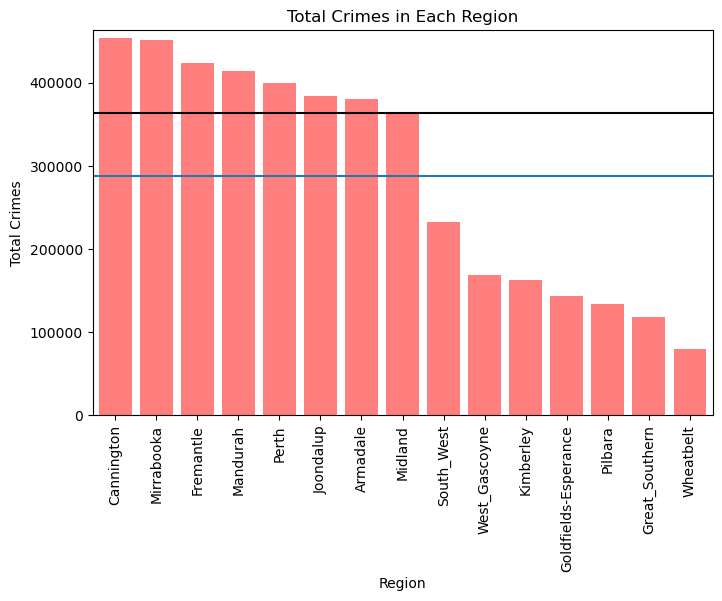

In [24]:
# Set x axis and tick locations
x_axis = np.arange(len(big_small))
tick_locations = [value+0.4 for value in x_axis]

 # Create a list indicating where to write x labels and set figure size to adjust for space

plt.figure(figsize=(8,5))
plt.bar(x_axis, big_small["Total"], color='r', alpha=0.5, align="edge")
plt.xticks(tick_locations, big_small["Region"], rotation="vertical")

 # Set x and y limits
plt.xlim(-0.15, len(x_axis)-0.05)
plt.ylim(0, max(big_small["Total"])+10000)

 # Set a Title and labels
plt.title("Total Crimes in Each Region")
plt.xlabel("Region")
plt.ylabel("Total Crimes")

#Line for average and median
mean = small_big["Total"].mean()
median = small_big["Total"].median()
plt.axhline(mean)
plt.axhline(median, color = "black")

# Save the figure
plt.savefig("figures/Fig1.png")

plt.show

In [19]:
metro_bigsmall = big_small.drop([3, 4, 6, 9, 13, 16])

metro_bigsmall

,Region,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Sexual Assault,Non-Assaultive Sexual Offences,Sexual Assault.1,Non-Assaultive Sexual Offences.1,Serious Assault (Family),...,Graffiti,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total,Lat,Lon
1,Cannington,45.0,16.0,8.0,41.0,2766.0,1269.0,1948.0,238.0,4209.0,...,5424.0,634.0,27064.0,21544.0,7454.0,1679.0,2033.0,453368.0,-32.020032,115.942916
11,Mirrabooka,61.0,34.0,10.0,41.0,2886.0,1892.0,2482.0,252.0,4538.0,...,7042.0,445.0,24891.0,22556.0,10232.0,1979.0,2539.0,451245.0,-31.862956,115.864238
2,Fremantle,38.0,13.0,6.0,52.0,2790.0,1513.0,1968.0,146.0,3365.0,...,6263.0,438.0,22134.0,18214.0,8262.0,1451.0,1739.0,423293.0,-32.053409,115.758617
7,Mandurah,41.0,35.0,17.0,64.0,4657.0,1511.0,3797.0,321.0,4318.0,...,9150.0,244.0,10965.0,13165.0,12783.0,2232.0,2907.0,414238.0,-32.530249,115.720878
12,Perth,27.0,13.0,11.0,27.0,3307.0,2568.0,1638.0,397.0,2074.0,...,15423.0,746.0,27926.0,25540.0,4003.0,1242.0,918.0,399747.0,-31.955893,115.860585
5,Joondalup,49.0,24.0,14.0,63.0,4171.0,1987.0,3124.0,316.0,3544.0,...,7632.0,319.0,10786.0,15454.0,11919.0,2032.0,2456.0,383513.0,-31.77955,115.764745
0,Armadale,33.0,19.0,9.0,60.0,3841.0,1338.0,2945.0,373.0,4551.0,...,9492.0,259.0,14869.0,14633.0,12836.0,1808.0,2340.0,380851.0,-32.152266,116.014746
10,Midland,42.0,22.0,8.0,60.0,3488.0,1817.0,3195.0,352.0,4133.0,...,12534.0,307.0,10097.0,13443.0,9026.0,1612.0,2255.0,363950.0,-31.88901,116.002453
15,South_West,32.0,5.0,5.0,82.0,2232.0,896.0,2095.0,176.0,2387.0,...,4047.0,294.0,3267.0,8674.0,7181.0,1448.0,1691.0,232214.0,-31.998671,115.870642


<function matplotlib.pyplot.show(close=None, block=None)>

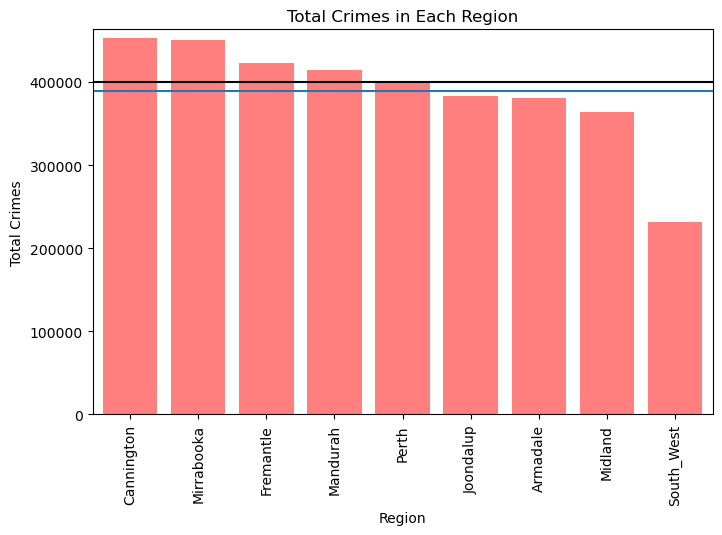

In [25]:
# Set x axis and tick locations
x_axis = np.arange(len(metro_bigsmall))
tick_locations = [value+0.4 for value in x_axis]

 # Create a list indicating where to write x labels and set figure size to adjust for space

plt.figure(figsize=(8,5))
plt.bar(x_axis, metro_bigsmall["Total"], color='r', alpha=0.5, align="edge")
plt.xticks(tick_locations, metro_bigsmall["Region"], rotation="vertical")

 # Set x and y limits
plt.xlim(-0.15, len(x_axis)-0.05)
plt.ylim(0, max(metro_bigsmall["Total"])+10000)

 # Set a Title and labels
plt.title("Total Crimes in Each Region")
plt.xlabel("Region")
plt.ylabel("Total Crimes")

#Line for average and median
mean = metro_bigsmall["Total"].mean()
median = metro_bigsmall["Total"].median()
plt.axhline(mean)
plt.axhline(median, color = "black")

# Save the figure
plt.savefig("figures/Fig2.png")

plt.show